In [58]:
%matplotlib inline
import re
from collections import defaultdict
import numpy as np
from sklearn.decomposition import PCA, LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.stem.snowball import SnowballStemmer
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from prep import *
import pandas as pd

## Abstract

We will implement various unsupervised methods on Amazon Fine Food Reviews [1]. The dataset consists of reviews of fine foods from Amazon. The overview of the dataset is as at the end of this document.

In this project, we want to cluster the dataset into two clusters: positive review and negative review. To do that we will do dimensionality reduction using Principal Component Analysis, t-sne and Latent Dirichlet Allocation, and compare the results to know which method works better for this case and discuss why it works or not. For the clustering, we will try various clustering methods we have learnt in class. For example: k-means, GMM, or DBScan. Again, we will discuss the result to know which clustering methods work best for this kind of data. For the data pre-processing on the review dataset, we will follow the standard procedure on text, which are stopwords removal and stemming and then convert it into vectors of tf-idf or bag of words.

Furthermore on this analysis, we will not only utilize the reviews from the user, but also we will use a transaction data to see what combinations of products a user usually buy using FP-Growth algorithm.

[1] http://snap.stanford.edu/data/web-FineFoods.html


## Milestone 1 - Exploratory Data Analysis

Data Cleaning:
1. Remove duplicated reviews:  
We can see the  the dataset has duplication reviews for one review.
Remove empty reviews. Also for one review, two records have different Helpfulness Denominator and Helpfulness Numerator. In that case, we assume the record is cumulated and only kept the record with largest number of Helpfulness Denominator.  
2. Remove the empty reviews:
The purpose of the project is to do semantic analysis for customer reviews. When reviews are not applicable, that review is not helpful. We remove the empty review.


Here, we have cleaned our numerical and categorical datasets and made it as pickle, so that we can just load it

In [19]:
all_reviews_df = pd.read_pickle("./dataframes/All_reviews.pkl")
all_reviews_df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


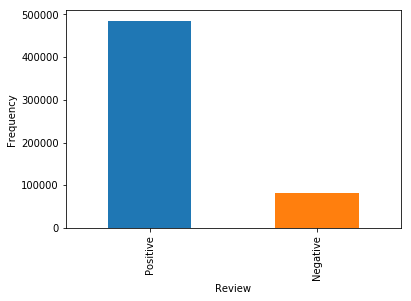

In [23]:
def polarity(x):
    if x < 3:
        # Means negative
        return "Negative"
    else:
        # Means positive
        return "Positive"
    
all_reviews_df["ScoreAsCategory"] = all_reviews_df["Score"].map(polarity)

ax = all_reviews_df["ScoreAsCategory"].value_counts().plot(kind="bar")
ax.set_xlabel("Review")
ax.set_ylabel("Frequency")
plt.show()

Here, we will do text and summary pre-processing, both will be stored to two text files text_prep.txt and summary_prep.txt

In [ ]:
rtitle = re.compile(r'^review\/text:\s*(.+)')
stemmer = SnowballStemmer('english')
texts = []
stopwords = []
parsed_titles = []

with open('stopwords_english.txt') as fsw:
    for word in fsw.readlines():
        word = word.strip('\n')
        stopwords.append(word)
fsw.close()

with open('finefoods.txt', encoding='latin-1') as fin:
    for line in fin.readlines():
        line = line.strip('\n')
        mtext = rtitle.match(line)
        ## if it is a title string
        if mtext:
            text = mtext.group(1).lower()
            texts.append(text[:-1])
fin.close()

fout = open('text_prep.txt', 'w+')
for i, words in enumerate(texts):
    words = words.split(" ")
    words = [re.match('[a-zA-Z0-9]+', stemmer.stem(word)).group() for word in words if re.match('[a-zA-Z0-9]+', stemmer.stem(word)) is not None]
    words = ['NUM' if re.match('[0-9]+', word) is not None else word for word in words]
    words = list(filter(None, ["" if word in stopwords else word for word in words]))
    words = ' '.join(words)
    fout.write(words + '\n')
    parsed_titles.append(words)
    if i % 100000 == 0 :
        print(i)
fout.close()

0
100000
200000
300000
400000
500000


In [14]:
rtitle = re.compile(r'^review\/summary:\s*(.+)')
stemmer = SnowballStemmer('english')
texts = []
stopwords = []
parsed_titles = []

with open('stopwords_english.txt') as fsw:
    for word in fsw.readlines():
        word = word.strip('\n')
        stopwords.append(word)
fsw.close()

with open('finefoods.txt', encoding='latin-1') as fin:
    for line in fin.readlines():
        line = line.strip('\n')
        mtext = rtitle.match(line)
        ## if it is a title string
        if mtext:
            text = mtext.group(1).lower()
            texts.append(text[:-1])
fin.close()

fout = open('summary_prep.txt', 'w+')
for i, words in enumerate(texts):
    words = words.split(" ")
    words = [re.match('[a-zA-Z0-9]+', stemmer.stem(word)).group() for word in words if re.match('[a-zA-Z0-9]+', stemmer.stem(word)) is not None]
    words = ['NUM' if re.match('[0-9]+', word) is not None else word for word in words]
    words = list(filter(None, ["" if word in stopwords else word for word in words]))
    words = ' '.join(words)
    fout.write(words + '\n')
    parsed_titles.append(words)
    if i % 100000 == 0 :
        print(i)
fout.close()

0
100000
200000
300000
400000
500000


In [37]:
"""
load dataset and convert bag of words represenetations.
"""
with open("./text_prep.txt", "r") as t:
    df = t.read()
    df = df.split("\n")

vec = CountVectorizer(min_df=800, max_features=1023)
df = vec.fit_transform(df)

In [56]:
# We will see the top 10 words appears the most

count_df = df.toarray().sum(axis=0)
vocab = {v: k for k, v in vec.vocabulary_.items()}
[(vocab[i], vec.vocabulary_[vocab[i]]) for i in count_df.argsort()[-10:][::-1]]

[('like', 496),
 ('tast', 887),
 ('good', 380),
 ('flavor', 345),
 ('one', 603),
 ('love', 514),
 ('product', 689),
 ('use', 953),
 ('great', 388),
 ('veri', 963)]

We will try to run LDA over our dataset for 10 topics to see the topics

In [16]:
def topwords_pca(cv, pca, num_topwords):
    """
    print the top words based on the eigenvectors 
    """
    Topwords = []
    vocab = {v: k for k, v in cv.vocabulary_.items()}
    eigenvectors = pca.components_
    for k,ev in enumerate(eigenvectors):
        ev_indices = np.argsort(- np.abs(ev))[:num_topwords]
        ev_topwords =', '.join([vocab[ind] for ind in ev_indices])
        Topwords.append(ev_topwords)
        print("Component : %d, topwords : %s" % (k, ev_topwords))

In [18]:
lda = LatentDirichletAllocation(n_components=10, n_jobs=1)
lda.fit(df)
# reduced_X = lda.transform(df)
print("======================================================")
print("Components: {0}".format(10))
print("======================================================")
topwords_pca(vec, lda, num_topwords=10)
print("------------------------------------------------------")

Components: 10
Component : 0, topwords : bar, love, eat, free, gluten, snack, protein, tast, great, organ
Component : 1, topwords : use, salt, mix, butter, make, tast, peanut, like, great, popcorn
Component : 2, topwords : love, find, amazon, store, great, use, buy, price, local, get
Component : 3, topwords : like, tast, flavor, chocol, good, chip, cooki, eat, snack, bag
Component : 4, topwords : order, product, amazon, price, box, buy, veri, good, ship, purchas
Component : 5, topwords : flavor, hot, make, great, good, like, veri, love, add, tast
Component : 6, topwords : tea, coffe, flavor, cup, like, coffee, tast, good, drink, one
Component : 7, topwords : dog, treat, get, love, one, like, time, day, use, give
Component : 8, topwords : tast, like, use, water, product, drink, sugar, flavor, oil, tri
Component : 9, topwords : food, cat, dog, eat, like, feed, love, chicken, one, dri
------------------------------------------------------


We can see the category for each topic, for example the first topic talks about snack, most likelike protein bar like and while the second topic is lilely about salt and butter. We couldn't tell much from this.

In [59]:
"""
load dataset and convert bag of words represenetations.
"""
with open("./text_prep.txt", "r") as t:
    df = t.read()
    df = df.split("\n")

tfidf = TfidfVectorizer(min_df=800, max_features=1023)
df_tfidf = tfidf.fit_transform(df)

Now, we will try to make the text as TF-IDF to see if it makes a difference

In [60]:
lda = LatentDirichletAllocation(n_components=10, n_jobs=1)
lda.fit(df_tfidf)
# reduced_X = lda.transform(df)
print("======================================================")
print("Components: {0}".format(10))
print("======================================================")
topwords_pca(vec, lda, num_topwords=10)
print("------------------------------------------------------")

Components: 10
Component : 0, topwords : use, make, cook, add, great, tast, like, good, rice, mix
Component : 1, topwords : amazon, price, store, find, great, buy, love, bar, local, product
Component : 2, topwords : tea, flavor, green, hot, tast, like, drink, good, sauc, love
Component : 3, topwords : coffe, coffee, cup, flavor, like, strong, tast, roast, good, blend
Component : 4, topwords : dog, food, cat, treat, love, eat, like, one, get, chew
Component : 5, topwords : chip, salt, popcorn, flavor, like, tast, bag, chips, good, great
Component : 6, topwords : chocol, tast, like, flavor, candi, sugar, bar, sweet, good, syrup
Component : 7, topwords : order, product, veri, box, arriv, receiv, amazon, time, packag, great
Component : 8, topwords : cooki, gluten, love, like, eat, free, tast, great, good, bread
Component : 9, topwords : drink, water, tast, like, use, product, tea, bottl, help, good
------------------------------------------------------


--------------------------------------------------------------------------------------------------------